In [5]:
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import matplotlib.patches as mpatches
from lifelines.utils import concordance_index
import scipy
from scipy import stats
from scipy.stats import linregress
from scipy.special import gamma
from scipy.cluster.hierarchy import linkage, cophenet, dendrogram, fcluster
from scipy.spatial.distance import pdist
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering

fontsize = 14
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
legend_size =14
plt.rc('font', size=MEDIUM_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

font = {'family': 'normal',
        'weight': 'bold',
        'size': 24}

plt.rc('font', **font)
params = {'legend.fontsize': 'x-large',
          # 'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.rcParams.update(params)
import seaborn as sns
import pandas
sns.set_style('white')
sns.set_context('paper')
sns.set()
seed=31415
np.random.seed(seed)

In [51]:
#
model = 'CSA-INFO'
is_non_param = True
is_stochastic = True

if 'SR' in model:
    is_stochastic = False
    
if 'AFT' in model:
    is_non_param = False      
    
data = 'framingham'

if data =='framingham':
    alpha = "01"
else:
    alpha = '0'

if alpha:
    main_path = 'analysis/{}/alpha_{}/'.format(data, alpha)
    path = 'analysis/{}/alpha_{}/{}/'.format(data, alpha, model)
else:
    path = 'analysis/{}/{}/'.format(data, model)
    main_path = 'analysis/{}/'.format(data)


#data = 'sythentic'
#path = 'analysis/{}/alpha_{}/{}/'.format(fld,alpha,  model)

print(path)
has_cf = True
if 'simulated' in data:
    time = 'days'
    is_simulated = True
else:
    is_simulated = False
    time = 'days'
if is_non_param:
    pred_t0_f = np.load(path + 'Test_pred_t0_F.npy')
    pred_t0_cf = np.load(path +  'Test_pred_t0_CF.npy')

    pred_t1_f = np.load(path +  'Test_pred_t1_F.npy')
    pred_t1_cf = np.load(path +  'Test_pred_t1_CF.npy')
    print("pred_t0_f: ", pred_t0_f.shape)
    print("pred_t0_cf: ", pred_t0_cf.shape)

    print("pred_t1_f: ", pred_t1_f.shape)
    print("pred_t1_cf: ", pred_t1_cf.shape)
    
    pred_c0_f = np.load(path + 'Test_pred_c0_F.npy')
    pred_c0_cf = np.load(path +  'Test_pred_c0_CF.npy')

    pred_c1_f = np.load(path +  'Test_pred_c1_F.npy')
    pred_c1_cf = np.load(path +  'Test_pred_c1_CF.npy')
    
    print("pred_c0_f: ", pred_c0_f.shape)
    print("pred_c0_cf: ", pred_c0_cf.shape)

    print("pred_c1_f: ", pred_c1_f.shape)
    print("pred_c1_cf: ", pred_c1_cf.shape)
    
else:
    pred_t0_f = pandas.read_csv(path + 'Test_pred_t0_F.csv')
    pred_t0_cf = pandas.read_csv(path +  'Test_pred_t0_CF.csv')

    pred_t1_f = pandas.read_csv(path +  'Test_pred_t1_F.csv')
    pred_t1_cf = pandas.read_csv(path +  'Test_pred_t1_CF.csv')
    
    print("pred_t0_f: ", pred_t0_f.shape,pred_t0_f.head())
    print("pred_t0_cf: ", pred_t0_cf.shape, pred_t0_cf.head())

    print("pred_t1_f: ", pred_t1_f.shape, pred_t1_f.head())
    print("pred_t1_cf: ", pred_t1_cf.shape, pred_t1_cf.head())



analysis/framingham/alpha_01/CSA-INFO/
pred_t0_f:  (455, 200)
pred_t0_cf:  (60, 200)
pred_t1_f:  (60, 200)
pred_t1_cf:  (455, 200)
pred_c0_f:  (455, 200)
pred_c0_cf:  (60, 200)
pred_c1_f:  (60, 200)
pred_c1_cf:  (455, 200)


In [52]:
if data == 'framingham':
    covariates = ['age6', 'age61', 'age62', 'ascvd_hx6', 'bmi6', 'bmi61', 'bmi62', 'bpmeds6',
                  'chol5', 'chol51', 'chol52', 'dbp6', 'dbp61', 'dbp62', 'diab6', 'female',
                  'gluc5', 'gluc51', 'gluc52', 'hdl5', 'hdl51', 'hdl52',
                  'pad_hx6', 'sbp6', 'sbp61', 'sbp62', 'smoke6', 'stk_hx6', 'mi_hx6',
                  'trigly5', 'trigly51', 'trigly52']

    print("covariates: ", len(covariates))

    sub_covariates = ['age6', 'ascvd_hx6', 'bmi6', 'bpmeds6','chol5', 'dbp6', 'diab6', 'female', 'gluc5',  'hdl5', 
                  'pad_hx6', 'sbp6', 'smoke6', 'stk_hx6', 'mi_hx6',  'trigly5']

    print("sub_covariates", len(sub_covariates))
else:
    covariates =  ['age', 'wtkg', 'hemo', 'homo', 'drugs', 'karnof', 'oprior','z30', 'zprior',
                   'preanti', 'race', 'gender', 'str2', 'strat','symptom', 'treat', 'offtrt', 
                   'cd40', 'cd420', 'cd496', 'r', 'cd80','cd820']
    print("covariates: ", len(covariates))
    
    sub_covariates = covariates

covariates:  32
sub_covariates 16


In [53]:
if is_simulated:
    dir_path = 'data/{}/'.format(data)
    path_factual =  dir_path + 'event_pairs.csv' 
    path_covariates = dir_path +  'covariates.npy'
    path_treatment = dir_path + 'treatment.npy'
    print("path:{}".format(path_factual))
    data_frame = pandas.read_csv(path_factual)
    print("head of data:{}, data shape:{}".format(data_frame.head(), data_frame.shape))

    idx = np.load(dir_path + 'test_idx.npy')

    # Preprocess
    a = np.load(path_treatment)[idx]

    ## Factual
    y_f = data_frame[['y_f']]
    e_f = data_frame[['e_f']]
    t_f = data_frame[['t_f']]

    y_f = np.array(y_f).reshape(len(y_f))[idx]
    e_f = np.array(e_f).reshape(len(e_f))[idx]
    t_f = np.array(t_f).reshape(len(t_f))[idx]

    ## Counter Factual
    y_cf = data_frame[['y_cf']]
    e_cf = data_frame[['e_cf']]
    t_cf = data_frame[['t_cf']]

    y_cf = np.array(y_cf).reshape(len(y_cf))[idx]
    e_cf = np.array(e_cf).reshape(len(e_cf))[idx]
    t_cf = np.array(t_cf).reshape(len(t_cf))[idx]

    print("a: ", a.shape)

    print("y_cf: ", y_cf.shape)
    print("e_cf: ", e_cf.shape)
    print("t_cf: ", t_cf.shape)


    print("y_f: ", y_f.shape)
    print("e_f: ", e_f.shape)
    print("t_f: ", t_f.shape)

else:
    path_factual = 'data/{}/{}_test_idx.csv'.format(data, data)
    data_frame = pandas.read_csv(path_factual)
    ## Factual
    y_f = data_frame[['time']]
    e_f = data_frame[['event']]
    a = data_frame[['treatment']]
    x = data_frame[covariates]
    
    y_f = np.array(y_f).reshape(len(y_f))
    e_f = np.array(e_f).reshape(len(e_f))
    a = np.array(a).reshape(len(a))
    
    ## Counter Factual
    y_cf = data_frame[['nn_cf_y']]
    e_cf = data_frame[['nn_cf_e']]
 

    y_cf = np.array(y_cf).reshape(len(y_cf))
    e_cf = np.array(e_cf).reshape(len(e_cf))
    
    
    print("a: ", a.shape)
    
    print("y_cf: ", y_cf.shape)
    print("e_cf: ", e_cf.shape)

    print("y_f: ", y_f.shape)
    print("e_f: ", e_f.shape)
    print("a=1", np.sum(a))
    print("y_f[a==1.0].shape", y_f[a==1].shape)
    print("x: ", x.shape)
    print(x.head())
    

    




FileNotFoundError: [Errno 2] No such file or directory: 'data/framingham/framingham_test_idx.csv'

In [11]:
def hr_dist(hr, ms):
    perc_50 = np.round(np.percentile(hr, 50),2)
    perc_2_5 = np.round(np.percentile(hr, 2.5),2)
    perc_97_5 = np.round(np.percentile(hr, 97.5),2)
    print(ms, "{} ({}, {})".format(perc_50, perc_2_5, perc_97_5))
    

In [12]:
def compute_grad(surv, time):
    slope, intercept, r_value, p_value, std_err = linregress(x=time, y=surv) # 
    #print("slope: ", slope, "std_err: ", std_err)
    
    #gradient = [(y2-y0)/(x2-x0) for x2, x0, y2, y0 in zip(time[2:], time, surv[2:], surv)]
    

    return  slope
    

# Factual + Counter Factual Metrics

In [13]:

# T_0_pred #pred_t0_f, pred_t0_cf
# T_1_pred # pred_t1_f, pred_t1_cf

T_0_pred = np.concatenate((pred_t0_f, pred_t0_cf), axis=0)
T_1_pred = np.concatenate((pred_t1_cf,pred_t1_f), axis=0)

print("T_0_pred: ", T_0_pred.shape)
print("T_1_pred: ", T_1_pred.shape)
print("pred_t0_f: ", pred_t0_f.shape, "pred_t1_cf: ", pred_t1_cf.shape)
print("pred_t1_f: ", pred_t1_f.shape, "pred_t0_cf: ", pred_t0_cf.shape )
    

x_0 = x.iloc[a==0]
x_1 = x.iloc[a==1]

print(x_0.shape)
print(x_1.shape)

x0_x1_conc = pandas.concat([x_0, x_1], axis=0)

print(x0_x1_conc.shape)

zero = np.array([0])
all_t_range = np.concatenate((zero, np.sort(y_f)))
print("all_t_range: ", all_t_range.shape)

T_0_pred:  (158, 200)
T_1_pred:  (158, 200)
pred_t0_f:  (75, 200) pred_t1_cf:  (75, 200)
pred_t1_f:  (83, 200) pred_t0_cf:  (83, 200)
(75, 23)
(83, 23)
(158, 23)
all_t_range:  (159,)


In [14]:
x_0.describe()

,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,zprior,preanti,...,strat,symptom,treat,offtrt,cd40,cd420,cd496,r,cd80,cd820
count,75.000000,75.000000,75.000000,75.000000,75.00000,75.000000,75.000000,75.000000,75.0,75.000000,...,75.000000,75.000000,75.0,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
mean,34.946667,78.449073,0.146667,0.720000,0.08000,95.466667,0.013333,0.546667,1.0,369.213333,...,2.000000,0.226667,0.0,0.413333,342.973333,332.786667,314.966667,0.640000,966.813333,956.453333
std,8.959207,14.401434,0.356156,0.452022,0.27312,6.836574,0.115470,0.501170,0.0,432.271477,...,0.869918,0.421495,0.0,0.495748,111.325063,102.733622,135.104597,0.483232,417.995723,432.531214
min,14.000000,48.308400,0.000000,0.000000,0.00000,70.000000,0.000000,0.000000,1.0,0.000000,...,1.000000,0.000000,0.0,0.000000,159.000000,88.000000,50.000000,0.000000,333.000000,305.000000
25%,29.000000,70.154000,0.000000,0.000000,0.00000,90.000000,0.000000,0.000000,1.0,0.000000,...,1.000000,0.000000,0.0,0.000000,264.000000,271.500000,263.500000,0.000000,616.500000,661.500000
50%,34.000000,76.204800,0.000000,1.000000,0.00000,100.000000,0.000000,1.000000,1.0,195.000000,...,2.000000,0.000000,0.0,0.000000,323.000000,334.000000,307.500000,1.000000,952.000000,880.000000
75%,40.000000,86.142000,0.000000,1.000000,0.00000,100.000000,0.000000,1.000000,1.0,670.500000,...,3.000000,0.000000,0.0,1.000000,405.000000,395.000000,372.500000,1.000000,1130.500000,1140.000000
max,70.000000,149.000000,1.000000,1.000000,1.00000,100.000000,1.000000,1.000000,1.0,1500.000000,...,3.000000,1.000000,0.0,1.000000,612.000000,590.000000,857.000000,1.000000,2444.000000,2486.000000


In [15]:
x_1.describe()

,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,zprior,preanti,...,strat,symptom,treat,offtrt,cd40,cd420,cd496,r,cd80,cd820
count,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.0,83.000000,...,83.000000,83.000000,83.0,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000
mean,35.493976,77.780010,0.072289,0.722892,0.132530,96.144578,0.012048,0.626506,1.0,382.289157,...,2.048193,0.192771,1.0,0.325301,363.253012,402.108434,341.837349,0.554217,1011.843373,1020.120482
std,8.872228,13.077465,0.260540,0.450291,0.341127,5.371861,0.109764,0.486672,0.0,436.013664,...,0.854024,0.396873,0.0,0.471335,149.367924,156.010554,136.054869,0.500073,489.110978,465.300254
min,12.000000,53.100000,0.000000,0.000000,0.000000,80.000000,0.000000,0.000000,1.0,0.000000,...,1.000000,0.000000,1.0,0.000000,148.000000,101.000000,6.000000,0.000000,228.000000,224.000000
25%,29.000000,69.173600,0.000000,0.000000,0.000000,90.000000,0.000000,0.000000,1.0,0.000000,...,1.000000,0.000000,1.0,0.000000,253.500000,280.000000,307.500000,0.000000,690.000000,663.500000
50%,34.000000,75.751200,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,1.0,195.000000,...,2.000000,0.000000,1.0,0.000000,349.000000,406.000000,307.500000,1.000000,869.000000,929.000000
75%,40.500000,85.617000,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,1.0,727.000000,...,3.000000,0.000000,1.0,1.000000,439.500000,497.500000,381.500000,1.000000,1195.000000,1267.000000
max,59.000000,111.358800,1.000000,1.000000,1.000000,100.000000,1.000000,1.000000,1.0,1508.000000,...,3.000000,1.000000,1.0,1.000000,1199.000000,826.000000,874.000000,1.000000,2666.000000,2753.000000


## Estimate Hazard

Text(0.5, 0, 'Time (days)')

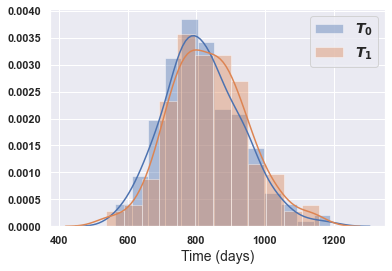

In [16]:
ex_i = 100
# 250 = negative, 500 = positive , 400 = neutral for framingham
# 90 = negative,  3=positive,  100=neutral actg175
sns.distplot(T_0_pred[ex_i], label='$T_0$')
sns.distplot(T_1_pred[ex_i], label='$T_1$')
plt.legend(loc='best', fontsize=legend_size)
plt.xlabel("Time ({})".format(time),  fontsize=fontsize)


Text(0.5, 0, 'Time (days)')

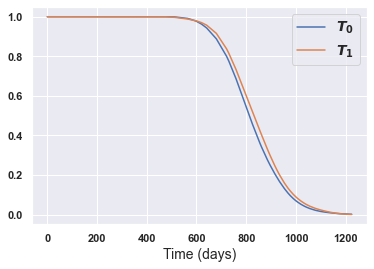

In [17]:
#t_emp_range = np.sort(np.concatenate((T_0_pred[ex_i], T_1_pred[ex_i]), axis=0))
t_emp_range = all_t_range
kernel_t0 = stats.gaussian_kde(T_0_pred[ex_i]) 
kernel_t1 = stats.gaussian_kde(T_1_pred[ex_i]) 

surv_t0  = []
surv_t1  = []
#print(np.sort(T_0_pred[1]))
for i in t_emp_range:
    surv_t0.append(1-kernel_t0.integrate_box_1d(low=0, high=i))
    surv_t1.append(1-kernel_t1.integrate_box_1d(low=0, high=i))
    
surv_t0 = np.array(surv_t0)
surv_t1 = np.array(surv_t1)

plt.plot(t_emp_range, surv_t0, label='$T_0$')
plt.plot(t_emp_range, surv_t1, label='$T_1$')
plt.legend(loc='best', fontsize=legend_size)
plt.xlabel("Time ({})".format(time),  fontsize=fontsize)

CSA-INFO mean: HR EST Slope  -0.23 (-0.39, -0.0)


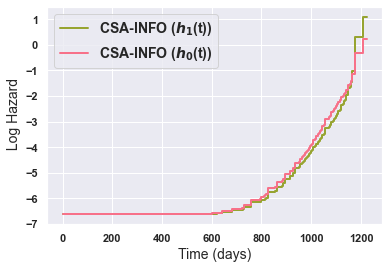

<Figure size 432x288 with 0 Axes>

In [18]:
s_0_prime_est = compute_grad(surv=surv_t0, time=t_emp_range)  
s_1_prime_est = compute_grad(surv=surv_t1, time=t_emp_range)


constant = 1e-8
surv_ratio = (surv_t0 + constant)/ (surv_t1 + constant)
surv_prime_ratio = (s_1_prime_est + constant )/(s_0_prime_est + constant)
HR_est_slope=  np.log(surv_ratio * surv_prime_ratio)
hr_dist(HR_est_slope, model + " mean: HR EST Slope ")

colors = sns.color_palette("husl", 4)
plt.xlabel("Time ({})".format(time),  fontsize=fontsize)
plt.ylabel(" Log Hazard",  fontsize=fontsize)

plt.step(t_emp_range, np.log(-s_1_prime_est / surv_t1),  label=model+' ($h_1$(t))', lw=2,
         color=colors[1])
plt.step(t_emp_range, np.log(-s_0_prime_est / surv_t0),  label=model+' ($h_0$(t))', lw=2,
        color=colors[0])


plt.legend(loc='best', fontsize=legend_size)
plt.show()
plt.tight_layout()




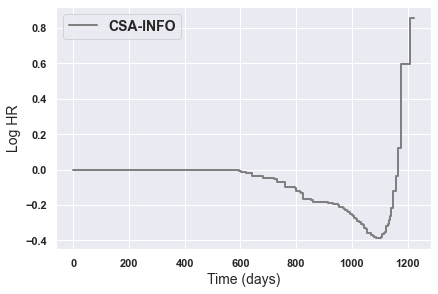

In [19]:
plt.step(t_emp_range, HR_est_slope, label=model, lw=2, color='grey')
plt.tight_layout()
plt.legend(loc='best', fontsize=legend_size)
plt.xlabel("Time ({})".format(time),  fontsize=fontsize)
plt.ylabel("Log HR",  fontsize=fontsize)
plt.show()


In [20]:
def compute_hr (t0_pred_i, t1_pred_i):
    #t_emp_range = np.sort(np.concatenate((t0_pred_i, t1_pred_i), axis=0))

    kernel_t0 = stats.gaussian_kde(t0_pred_i) 
    kernel_t1 = stats.gaussian_kde(t1_pred_i) 

    surv_t0  = []
    surv_t1  = []

    for i in all_t_range:
        surv_t0.append(1-kernel_t0.integrate_box_1d(low=0, high=i))
        surv_t1.append(1-kernel_t1.integrate_box_1d(low=0, high=i))
    
    surv_t0 = np.array(surv_t0)
    surv_t1 = np.array(surv_t1)
    
    s_0_prime_est = compute_grad(surv=surv_t0, time=t_emp_range)
    
    s_1_prime_est = compute_grad(surv=surv_t1, time=t_emp_range)

    #HR_est_slope= surv_t0/surv_t1 * (s_1_prime_est /s_0_prime_est)
    constant = 1e-8
    surv_ratio = surv_t0 / surv_t1
    surv_prime_ratio = s_1_prime_est / s_0_prime_est 
    HR_est_slope=  np.log( surv_ratio  *  surv_prime_ratio + constant)
    
    return HR_est_slope


In [21]:
all_HR = []
all_HR_median = []
for i in np.arange(T_0_pred.shape[0]):
    hr = compute_hr(t0_pred_i=T_0_pred[i], t1_pred_i=T_1_pred[i])
    all_HR_median.append(np.median(hr))
    all_HR.append(hr)


In [22]:
all_HR = np.array(all_HR)
all_HR_median = np.array(all_HR_median)

## Median Covariates  Statistics

In [23]:
print("positive: ", len(all_HR_median[all_HR_median < 0 ])/ len(all_HR_median))
pos_median = x0_x1_conc[all_HR_median < 0]

positive:  0.6455696202531646


In [24]:
pos_median[sub_covariates].describe()

,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,zprior,preanti,...,strat,symptom,treat,offtrt,cd40,cd420,cd496,r,cd80,cd820
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.0,102.000000,...,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,35.264706,78.217507,0.098039,0.745098,0.078431,96.176471,0.009804,0.676471,1.0,403.284314,...,2.186275,0.215686,0.539216,0.382353,343.137255,352.901961,298.813725,0.529412,895.480392,961.980392
std,8.565330,14.502873,0.298836,0.437958,0.270177,5.809538,0.099015,0.470133,0.0,393.324328,...,0.805063,0.413329,0.500921,0.488362,140.218220,134.380759,84.735667,0.501599,359.324717,472.597457
min,12.000000,53.100000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,1.0,0.000000,...,1.000000,0.000000,0.000000,0.000000,148.000000,98.000000,60.000000,0.000000,228.000000,224.000000
25%,29.250000,69.425600,0.000000,0.250000,0.000000,90.000000,0.000000,0.000000,1.0,20.500000,...,2.000000,0.000000,0.000000,0.000000,240.500000,267.750000,278.750000,0.000000,648.500000,644.750000
50%,34.000000,75.978000,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,1.0,318.000000,...,2.000000,0.000000,1.000000,0.000000,323.000000,336.000000,307.500000,1.000000,833.000000,870.000000
75%,40.000000,86.721000,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,1.0,728.750000,...,3.000000,0.000000,1.000000,1.000000,427.000000,419.750000,307.500000,1.000000,1076.750000,1121.750000
max,70.000000,149.000000,1.000000,1.000000,1.000000,100.000000,1.000000,1.000000,1.0,1500.000000,...,3.000000,1.000000,1.000000,1.000000,1199.000000,826.000000,533.000000,1.000000,2127.000000,2753.000000


In [25]:
print("negative", len(all_HR_median[all_HR_median > 0])/ len(all_HR_median))
neg_median = x0_x1_conc[all_HR_median>0]

negative 0.35443037974683544


In [26]:
neg_median[sub_covariates].describe()

,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,zprior,preanti,...,strat,symptom,treat,offtrt,cd40,cd420,cd496,r,cd80,cd820
count,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.0,56.000000,...,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000
mean,35.178571,77.879207,0.125000,0.678571,0.160714,95.178571,0.017857,0.428571,1.0,326.535714,...,1.732143,0.196429,0.500000,0.339286,372.732143,398.892857,384.214286,0.714286,1163.482143,1040.750000
std,9.531016,12.166405,0.333712,0.471251,0.370591,6.603325,0.133631,0.499350,0.0,496.992225,...,0.884021,0.400892,0.504525,0.477752,116.412197,139.206802,186.265960,0.455842,555.777522,403.951493
min,14.000000,48.308400,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,1.0,0.000000,...,1.000000,0.000000,0.000000,0.000000,172.000000,88.000000,6.000000,0.000000,333.000000,305.000000
25%,28.000000,69.963600,0.000000,0.000000,0.000000,90.000000,0.000000,0.000000,1.0,0.000000,...,1.000000,0.000000,0.000000,0.000000,279.750000,297.000000,307.500000,0.000000,733.000000,725.000000
50%,35.000000,76.150000,0.000000,1.000000,0.000000,100.000000,0.000000,0.000000,1.0,0.000000,...,1.000000,0.000000,0.500000,0.000000,371.500000,401.500000,323.750000,1.000000,1001.000000,992.500000
75%,41.000000,84.936600,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,1.0,562.000000,...,3.000000,0.000000,1.000000,1.000000,439.000000,476.250000,500.500000,1.000000,1456.000000,1307.250000
max,58.000000,110.451600,1.000000,1.000000,1.000000,100.000000,1.000000,1.000000,1.0,1508.000000,...,3.000000,1.000000,1.000000,1.000000,648.000000,750.000000,874.000000,1.000000,2666.000000,1947.000000


In [27]:
print("neutral", len(all_HR_median[all_HR_median == 0])/ len(all_HR_median))

neutral 0.0


## Cluster Map

In [28]:
linkage_data = linkage(all_HR, 'ward')
c, coph_dists = cophenet(linkage_data, pdist(all_HR))
print("preserved_distance:{}".format(c))



preserved_distance:0.9089860408745527


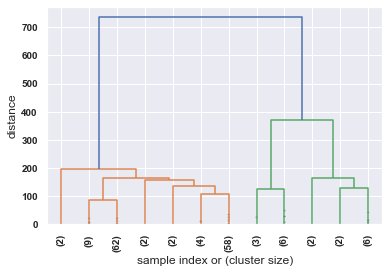

In [29]:

plt.figure()
    # plt.title('{} Hierarchical Clustering Dendrogram'.format(name), fontsize=title_fontsize)
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
        linkage_data,
        truncate_mode='lastp',  # show only the last p merged clusters
        p=12,  # show only the last p merged clusters
        leaf_rotation=90.,
        leaf_font_size=12,
        show_contracted=True,  # to get a distribution impression in truncated branches
    )
plt.tick_params(axis='both', which='major', labelsize=10)

/Users/paidamoyochapfuwa/.pyenv/versions/3.6.4/envs/csa_prod/lib/python3.6/site-packages/seaborn/matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 360x288 with 0 Axes>

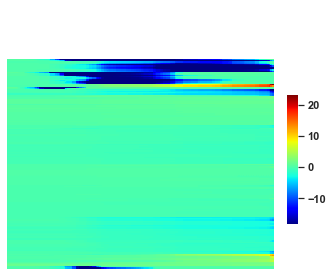

In [30]:
fig =plt.figure(figsize=(5,4))
g=sns.clustermap(all_HR,  cmap="jet", metric= 'euclidean', figsize=(5, 4),
                   yticklabels=False, xticklabels=False, col_cluster=False)
g.cax.set_position([1, .2, .03, .45])
g.ax_row_dendrogram.set_visible(False) 

In [31]:
if data == 'framingham':
    num_clusters = 4
else:
     num_clusters = 2
clusters = fcluster(linkage_data, num_clusters, criterion='maxclust')
print("clusters: ", clusters.shape, np.unique(clusters))


clusters:  (158,) [1 2]


c = 1  hr_c:  (139, 159)
c = 2  hr_c:  (19, 159)


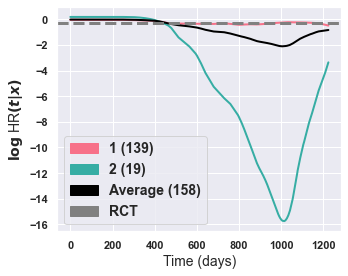

In [33]:
fig=plt.figure(figsize=(5,4))
model_colors = sns.color_palette("husl", num_clusters)
handles = []
for i in np.unique(clusters):
    idx = clusters == i
    hr_c = all_HR[idx]
    print('c =', i, " hr_c: ", hr_c.shape)
    mean_hr_c =  np.mean(hr_c, axis=0)
    handles.append(mpatches.Patch(color=model_colors[i-1], label="{} ({})".format(i, len(hr_c))))
    plt.plot(all_t_range, mean_hr_c, c=model_colors[i-1], linewidth=2)

handles.append(mpatches.Patch(color='black', label="{} ({})".format('Average', len(all_HR))))
handles.append(mpatches.Patch(color='grey', label="RCT"))
plt.plot(all_t_range, np.mean(all_HR, axis=0), c='black', linewidth=2)
plt.axhline(y= np.log(0.75), color='grey', label='mean', linestyle='--', lw=3)
ylabel =  '$\log$'  + ' ' +  'HR' + '$(t|x)$'    
plt.xlabel("Time ({})".format(time),  fontsize=fontsize)
plt.ylabel(ylabel ,  fontsize=fontsize)
plt.tight_layout()
#plt.legend(handles=handles, fontsize=legend_size, bbox_to_anchor=(0.95,1.05))
plt.legend(handles=handles, fontsize=legend_size, loc='best')

In [34]:
c1_cov = x0_x1_conc[clusters==1]
c1_cov[sub_covariates].describe()

,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,zprior,preanti,...,strat,symptom,treat,offtrt,cd40,cd420,cd496,r,cd80,cd820
count,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.0,139.000000,...,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000
mean,35.395683,77.004182,0.107914,0.712230,0.115108,95.755396,0.014388,0.582734,1.0,377.834532,...,2.007194,0.165468,0.525180,0.345324,364.474820,389.863309,344.870504,0.597122,1000.035971,983.561151
std,9.048676,12.022074,0.311393,0.454361,0.320306,6.135950,0.119517,0.494891,0.0,432.821073,...,0.863901,0.372946,0.501172,0.477193,134.173062,130.760551,133.204041,0.492250,468.072356,452.691006
min,12.000000,48.308400,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,1.0,0.000000,...,1.000000,0.000000,0.000000,0.000000,148.000000,88.000000,6.000000,0.000000,228.000000,224.000000
25%,29.000000,69.450400,0.000000,0.000000,0.000000,90.000000,0.000000,0.000000,1.0,0.000000,...,1.000000,0.000000,0.000000,0.000000,269.500000,300.500000,307.500000,0.000000,669.000000,660.000000
50%,34.000000,75.524400,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,1.0,195.000000,...,2.000000,0.000000,1.000000,0.000000,355.000000,372.000000,307.500000,1.000000,900.000000,905.000000
75%,40.000000,85.276800,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,1.0,682.500000,...,3.000000,0.000000,1.000000,1.000000,439.000000,459.500000,391.500000,1.000000,1167.500000,1182.500000
max,70.000000,115.900000,1.000000,1.000000,1.000000,100.000000,1.000000,1.000000,1.0,1508.000000,...,3.000000,1.000000,1.000000,1.000000,1199.000000,826.000000,874.000000,1.000000,2666.000000,2753.000000


In [35]:
c2_cov = x0_x1_conc[clusters==2]
c2_cov[sub_covariates].describe()

,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,zprior,preanti,...,strat,symptom,treat,offtrt,cd40,cd420,cd496,r,cd80,cd820
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.0,19.000000,19.0,19.000000,...,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,34.052632,86.096842,0.105263,0.789474,0.052632,96.315789,0.0,0.631579,1.0,363.263158,...,2.157895,0.526316,0.526316,0.526316,274.263158,218.052632,213.578947,0.578947,920.473684,1036.263158
std,7.735012,21.163191,0.315302,0.418854,0.229416,5.972647,0.0,0.495595,0.0,445.188580,...,0.834210,0.512989,0.512989,0.512989,88.952448,79.295841,94.392394,0.507257,356.335885,436.562945
min,21.000000,58.200000,0.000000,0.000000,0.000000,80.000000,0.0,0.000000,1.0,0.000000,...,1.000000,0.000000,0.000000,0.000000,151.000000,98.000000,60.000000,0.000000,438.000000,535.000000
25%,29.000000,71.101800,0.000000,1.000000,0.000000,90.000000,0.0,0.000000,1.0,8.500000,...,1.500000,0.000000,0.000000,0.000000,198.000000,159.500000,151.000000,0.000000,681.500000,730.500000
50%,37.000000,80.514000,0.000000,1.000000,0.000000,100.000000,0.0,1.000000,1.0,160.000000,...,2.000000,1.000000,1.000000,1.000000,262.000000,209.000000,218.000000,1.000000,827.000000,882.000000
75%,39.000000,94.450000,0.000000,1.000000,0.000000,100.000000,0.0,1.000000,1.0,590.000000,...,3.000000,1.000000,1.000000,1.000000,322.500000,259.000000,307.500000,1.000000,1118.500000,1313.000000
max,46.000000,149.000000,1.000000,1.000000,1.000000,100.000000,0.0,1.000000,1.0,1500.000000,...,3.000000,1.000000,1.000000,1.000000,466.000000,384.000000,307.500000,1.000000,1890.000000,2068.000000


In [36]:
c3_cov = x0_x1_conc[clusters==3]
c3_cov[sub_covariates].describe()

,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,zprior,preanti,...,strat,symptom,treat,offtrt,cd40,cd420,cd496,r,cd80,cd820
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
c4_cov = x0_x1_conc[clusters==4]
c4_cov[sub_covariates].describe()

,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,zprior,preanti,...,strat,symptom,treat,offtrt,cd40,cd420,cd496,r,cd80,cd820
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# TSNE

In [38]:
perp=50
tsne = TSNE(random_state=seed, perplexity=perp, verbose=1, n_components=2, init='pca', n_iter=5000)
tsne_all_HR = tsne.fit_transform(all_HR)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 158 samples in 0.000s...
[t-SNE] Computed neighbors for 158 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 158 / 158
[t-SNE] Mean sigma: 5.405515
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.882069
[t-SNE] KL divergence after 1350 iterations: 0.081494


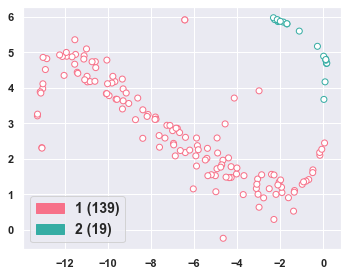

In [39]:
fig=plt.figure(figsize=(5,4))
size = len(all_HR)

plt.scatter(tsne_all_HR[0:size, 0], tsne_all_HR[0:size, 1], 
            edgecolors=[model_colors[i-1] for i in clusters],
            cmap='prism', c="w",  marker="o", label='Z')  

plt.tight_layout()
plt.legend(handles=handles[0:num_clusters], fontsize=legend_size, loc='best')


In [40]:
r1_f = np.load(path + 'Test_r1_F.npy')
r1_cf = np.load(path + 'Test_r1_CF.npy')

r0_f = np.load(path + 'Test_r0_F.npy')
r0_cf = np.load(path + 'Test_r0_CF.npy')

print("r1_f: ", r1_f.shape)
print("r1_cf: ", r1_cf.shape)

print("r0_f: ", r0_f.shape)
print("r0_cf: ", r0_cf.shape)

r1_f:  (83, 100)
r1_cf:  (75, 100)
r0_f:  (75, 100)
r0_cf:  (83, 100)


In [41]:
perp=50
tsne = TSNE(random_state=seed, perplexity=perp, verbose=1, n_components=2, init='pca', n_iter=5000)
r_factuals = np.concatenate((r1_f, r0_f), axis=0)
tsne_factuals = tsne.fit_transform(r_factuals)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 158 samples in 0.000s...
[t-SNE] Computed neighbors for 158 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 158 / 158
[t-SNE] Mean sigma: 0.075122
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.455025
[t-SNE] KL divergence after 900 iterations: 0.206484


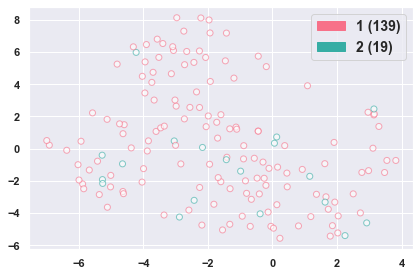

In [42]:

size = len(tsne_factuals)
plt.scatter(tsne_factuals[0:size, 0], tsne_factuals[0:size, 1], 
            edgecolors=[model_colors[i-1] for i in clusters],
            cmap='prism', c="w",  marker="o", label='$r$', alpha=0.6)  

plt.tight_layout()
plt.legend(handles=handles[0:num_clusters], fontsize=legend_size, loc='best')


## Median LogHarzard Ratio

25:  0.379 75:  1.221 50:  1.0 3


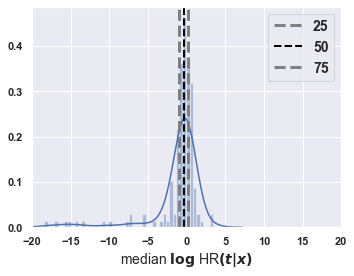

In [43]:
fig=plt.figure(figsize=(5,4))

perc_25 = np.round(np.percentile(all_HR_median, 25),2)
perc_50 = np.round(np.percentile(all_HR_median, 50),2)
perc_75 = np.round(np.percentile(all_HR_median, 75),2)

print("25: ", np.round(np.exp(perc_25), 3), "75: ",
      np.round(np.exp(perc_75), 3) , "50: ", np.round(np.exp(perc_50)), 3)

xlabel =  'median ' +'$\log$'  + ' ' +  'HR' + '$(t|x)$'
sns.distplot(all_HR_median)
plt.xlabel(xlabel ,  fontsize=fontsize)

plt.axvline(x=perc_25 ,color='grey', label='25', linestyle='--', lw=3)
plt.axvline(x=perc_50 ,color='black', label='50', linestyle='--', lw=2)
plt.axvline(x=perc_75 ,color='grey', label='75', linestyle='--', lw=3)
plt.tight_layout()
plt.xlim((-20, 20))
plt.legend(fontsize=legend_size, loc='best')


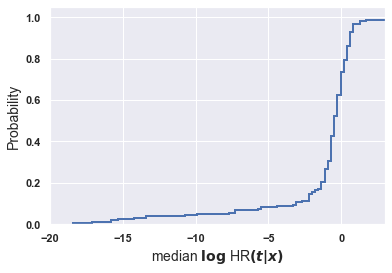

In [44]:
plt.hist(all_HR_median,cumulative=True, density=True, bins=100, histtype='step', linewidth=2)
#kwargs = {'cumulative': True}
#sns.distplot(all_HR_median, hist_kws=kwargs, kde_kws=kwargs)
plt.xlabel(xlabel ,  fontsize=fontsize)
plt.ylabel('Probability' ,  fontsize=fontsize)
if data == 'framingham':
    plt.xlim((-20, 20))
else:
    plt.xlim((-20, 3))

In [45]:
print("50",  np.round(np.percentile(all_HR_median, 50), 2))

50 -0.33


In [46]:
thresh = np.round(np.percentile(all_HR_median, 25), 2)
print("thresh: ", thresh)

print("positive: ", len(all_HR_median[all_HR_median < thresh ])/ len(all_HR_median))
positive = x0_x1_conc[all_HR_median < thresh]


thresh:  -0.97
positive:  0.25316455696202533


In [47]:
if data == 'framingham':
    end = 8
    positive[sub_covariates[0:8]].describe()
else:
    end = 12

positive[sub_covariates[0:end]].describe()


,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,zprior,preanti,race,gender
count,40.000000,40.000000,40.000000,40.00000,40.000000,40.000000,40.0,40.000000,40.0,40.000000,40.00000,40.000000
mean,35.225000,82.585202,0.075000,0.85000,0.100000,96.250000,0.0,0.750000,1.0,420.375000,0.15000,0.950000
std,9.241732,17.215267,0.266747,0.36162,0.303822,5.856182,0.0,0.438529,0.0,380.919447,0.36162,0.220721
min,18.000000,58.060800,0.000000,0.00000,0.000000,80.000000,0.0,0.000000,1.0,0.000000,0.00000,0.000000
25%,29.750000,71.895600,0.000000,1.00000,0.000000,90.000000,0.0,0.750000,1.0,71.500000,0.00000,1.000000
50%,36.000000,78.881040,0.000000,1.00000,0.000000,100.000000,0.0,1.000000,1.0,373.000000,0.00000,1.000000
75%,39.250000,89.444400,0.000000,1.00000,0.000000,100.000000,0.0,1.000000,1.0,678.250000,0.00000,1.000000
max,70.000000,149.000000,1.000000,1.00000,1.000000,100.000000,0.0,1.000000,1.0,1500.000000,1.00000,1.000000


In [48]:
positive[sub_covariates[end:]].describe()

,str2,strat,symptom,treat,offtrt,cd40,cd420,cd496,r,cd80,cd820
count,40.000000,40.000000,40.000000,40.000000,40.00000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,0.825000,2.300000,0.300000,0.475000,0.50000,299.825000,290.900000,267.887500,0.475000,932.500000,1053.625000
std,0.384808,0.757865,0.464095,0.505736,0.50637,106.019081,128.585759,81.213354,0.505736,367.736946,567.631773
min,0.000000,1.000000,0.000000,0.000000,0.00000,148.000000,98.000000,60.000000,0.000000,438.000000,428.000000
25%,1.000000,2.000000,0.000000,0.000000,0.00000,209.750000,190.750000,217.250000,0.000000,718.750000,604.750000
50%,1.000000,2.000000,0.000000,0.000000,0.50000,305.000000,268.500000,307.500000,0.000000,833.500000,870.000000
75%,1.000000,3.000000,1.000000,1.000000,1.00000,374.250000,360.750000,307.500000,1.000000,1056.750000,1302.500000
max,1.000000,3.000000,1.000000,1.000000,1.00000,554.000000,755.000000,393.000000,1.000000,2127.000000,2753.000000


In [49]:
thresh = np.round(np.percentile(all_HR_median, 75), 2)
print("thresh: ", thresh)
print("negative", len(all_HR_median[all_HR_median > thresh])/ len(all_HR_median))
negative = x0_x1_conc[all_HR_median>thresh]

thresh:  0.2
negative 0.2468354430379747


In [43]:
negative[sub_covariates[0:end]].describe()

,age6,ascvd_hx6,bmi6,bpmeds6,chol5,dbp6,diab6,female
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,60.666667,0.139535,26.375823,0.286822,197.581395,71.627907,0.046512,0.604651
std,10.185263,0.347855,5.325558,0.454041,28.029197,11.657260,0.211411,0.490832
min,37.000000,0.000000,17.676632,0.000000,118.000000,49.000000,0.000000,0.000000
25%,53.000000,0.000000,22.687889,0.000000,180.000000,62.000000,0.000000,0.000000
50%,60.000000,0.000000,25.285077,0.000000,198.000000,70.000000,0.000000,1.000000
75%,69.000000,0.000000,29.230393,1.000000,217.000000,81.000000,0.000000,1.000000
max,78.000000,1.000000,45.992112,1.000000,290.000000,105.000000,1.000000,1.000000


In [44]:
negative[sub_covariates[end:]].describe()

,gluc5,hdl5,pad_hx6,sbp6,smoke6,stk_hx6,mi_hx6,trigly5
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,96.023256,58.550388,0.054264,128.007752,0.217054,0.046512,0.054264,119.937984
std,16.391912,16.147253,0.227420,22.184417,0.413847,0.211411,0.227420,133.107261
min,48.000000,22.000000,0.000000,88.000000,0.000000,0.000000,0.000000,33.000000
25%,88.000000,49.000000,0.000000,111.000000,0.000000,0.000000,0.000000,63.000000
50%,95.000000,59.000000,0.000000,126.000000,0.000000,0.000000,0.000000,87.000000
75%,101.000000,69.000000,0.000000,140.000000,0.000000,0.000000,0.000000,109.000000
max,228.000000,101.000000,1.000000,214.000000,1.000000,1.000000,1.000000,1149.000000


In [45]:
print(np.log(0.54), np.log(0.8))

-0.616186139423817 -0.2231435513142097
